In [217]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers

In [218]:
# Get data for a single stock relative daily return
stock_data = yf.download('AAPL', start='2016-01-01', end='2023-10-01')

[*********************100%%**********************]  1 of 1 completed


In [219]:
# Calculate logarithmic returns
stock_data['log_return'] = np.log(stock_data['Adj Close']).diff()

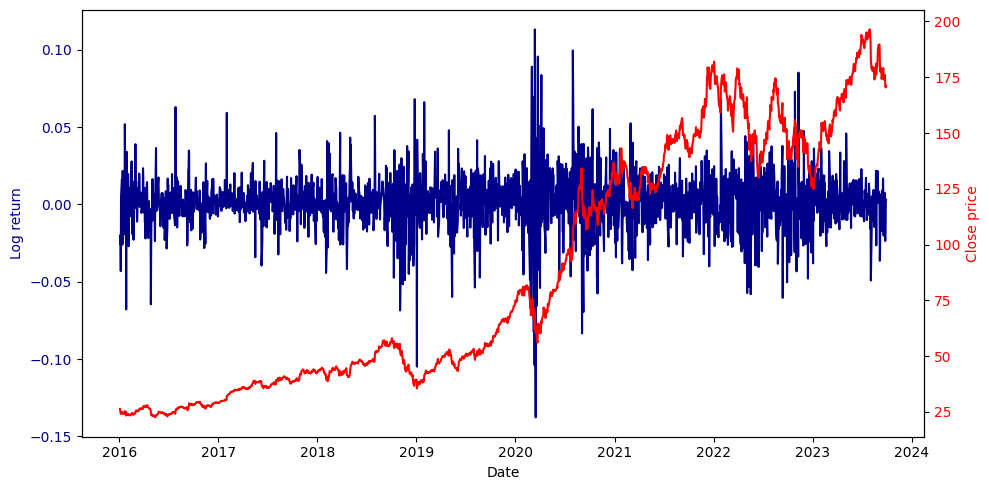

In [220]:
# Plot returns and stock price
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

color1 = 'darkblue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Log return', color=color1)
ax1.plot(stock_data['log_return'], color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

color2='red'
ax2.set_ylabel('Close price', color=color2)
ax2.plot(stock_data['Close'], color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout() 
plt.show()


In [221]:
tf.random.set_seed(7)

In [222]:
# Split data into train and test sets
data = stock_data['log_return'].values
train_data, test_data = train_test_split(data, test_size=0.20, random_state=1) #random_state seed for splitting, set to any number

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.fit_transform(test_data.reshape(-1, 1))

In [223]:
# Create datasets for train and test data
def create_dataset(dataset, loopback):
    x, y = [], []
    for i in range(loopback, len(dataset)):
        x.append(dataset[i-loopback:i, 0])
        y.append(dataset[i, 0])
    return x, y

x_train, y_train = create_dataset(train_data, 1)
x_test, y_test = create_dataset(test_data, 1)
    
x_train, y_train, x_test= np.array(x_train), np.array(y_train), np.array(x_test)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [229]:
# LSTM model
model = keras.Sequential()
model.add(layers.LSTM(200, input_shape=(x_train.shape[1], 1)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='tanh'))
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 200)               161600    
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 201       
                                                                 
Total params: 161801 (632.04 KB)
Trainable params: 161801 (632.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [230]:
# Fit model
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.fit(x_train, y_train, batch_size= 1, epochs=1)

1558/1558 [==============================] - 6s 3ms/step - loss: 0.7593 - accuracy: 0.0013


In [231]:
# Predict test data and error
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)
#print(prediction)
err = np.sqrt(mean_squared_error(prediction[:30], y_test[:30]))

print(err)

13/13 [==============================] - 0s 3ms/step
0.5605299519111611


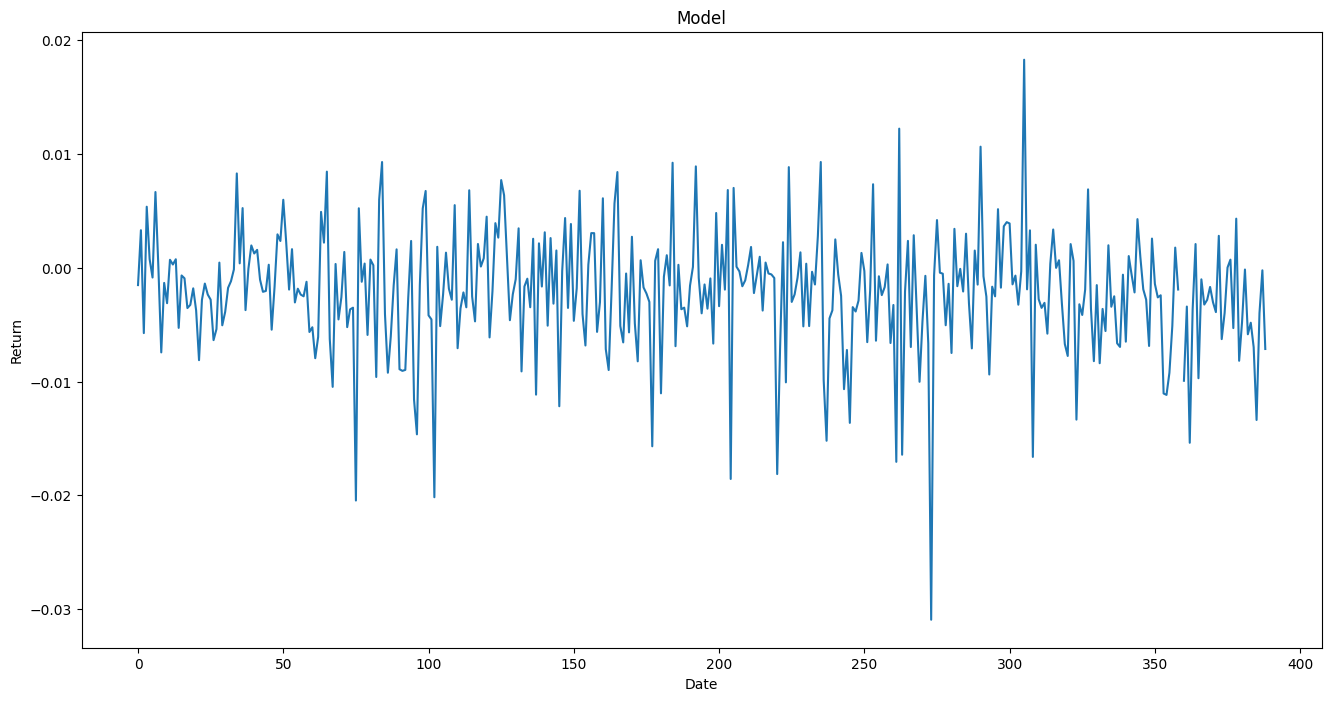

In [232]:
# Plot prediction
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Return')
plt.plot(prediction)

C:\Users\piotr\AppData\Local\Temp\ipykernel_12776\2069691230.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction']=prediction


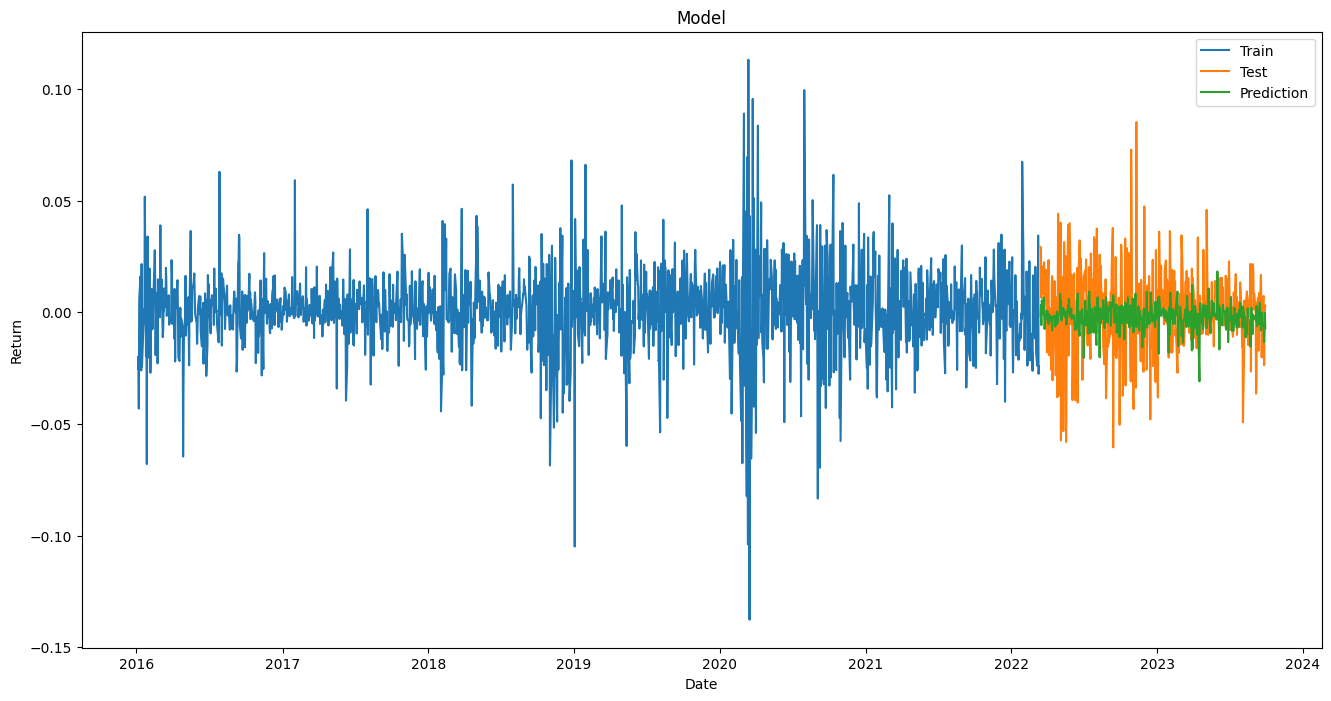

In [233]:
# Compare prediction with test data 
data = stock_data.filter(['log_return'])
train = data[:len(train_data)]
test = data[len(train_data)+1:]
test['Prediction']=prediction
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Return')
plt.plot(train)
plt.plot(test)
plt.legend(['Train', 'Test', 'Prediction'])
plt.show()